## Avance 2. Ingeniería de características

Antes de comenzar con el proceso de ingenieria de caracteristicas, se desarrolla una clase de base de datos de pytorch para importar las matrices de entrada y salida

In [1]:
import numpy as np
import os
from scipy.interpolate import griddata
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# funcion para importar y transformar la martriz de estres

def read(filename):
    x_list, y_list, stresses = [], [], []

    with open(filename, 'r') as f:
        next(f)  # Skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 5:
                continue
            # Extract and clean X, Y values (handle trailing dots)
            x = float(parts[1].rstrip('.'))
            y = float(parts[2].rstrip('.'))
            stress = float(parts[4])
            x_list.append(x)
            y_list.append(y)
            stresses.append(stress)


    scaling = 4

    # Scale coordinates to integers
    scaled_x = [int(round(x * scaling)) for x in x_list]
    scaled_y = [int(round(y * scaling)) for y in y_list]

    # Create mappings from unique scaled coordinates to indices
    unique_x = sorted(set(scaled_x))
    unique_y = sorted(set(scaled_y))
    x_to_idx = {x: idx for idx, x in enumerate(unique_x)}
    y_to_idx = {y: idx for idx, y in enumerate(unique_y)}

    # Initialize matrix with NaNs
    matrix = np.full((len(unique_y), len(unique_x)), np.nan)

    # Populate the matrix with stress values
    for x, y, stress in zip(scaled_x, scaled_y, stresses):
        xi = x_to_idx[x]
        yi = y_to_idx[y]
        if matrix[yi, xi] is np.nan:
            matrix[yi, xi] = stress
        else:
            matrix[yi, xi]= (matrix[yi, xi] + stress) / 2

    # Prepare grid coordinates for interpolation
    grid_x, grid_y = np.meshgrid(unique_x, unique_y)
    points = np.array([[x, y] for x, y in zip(scaled_x, scaled_y)])
    values = np.array(stresses)

    # Interpolate missing values
    filled_matrix = griddata(points, values, (grid_x, grid_y), method='linear')
    flipped_matrix = filled_matrix[::-1, :].copy()


    return flipped_matrix


In [7]:

class StressDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.data = []

        # Iterar sobre las carpetas dentro del root_folder
        for folder_name in sorted(os.listdir(root_folder)):
            if not folder_name.isdigit():  # Ignorar nombres no numéricos
                continue

            folder_path = os.path.join(root_folder, folder_name)
            if os.path.isdir(folder_path):
                image_path = os.path.join(folder_path, "image.png")
                label_path = os.path.join(folder_path, "data2.txt")

                # Verificar que ambos archivos existen
                if os.path.exists(image_path) and os.path.exists(label_path):
                    stress_array = read(label_path)
                    self.data.append((image_path, stress_array))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, stress_grid = self.data[idx]

        # Abrir la imagen en escala de grises
        image = Image.open(image_path).convert("L")
        stress_grid = Image.fromarray(stress_grid)

        # Aplicar transformaciones si están definidas
        if self.transform:
            image = self.transform(image)
            stress_grid = self.transform(stress_grid)
        else:
            image = transforms.ToTensor()(image)
            stress_grid = transforms.ToTensor()(stress_grid)

        return image, stress_grid


In [10]:

# Path to the root folder containing subfolders
root_folder = "/content/drive/MyDrive/Colab Notebooks/MNA - Colab/Proyecto Integrador/db/db/random"

# Define transformations (e.g., resize images, normalize them, etc.)
transform_pipeline = transforms.Compose([
    transforms.Resize((126, 126)),  # Resize to 128x128 pixels
    transforms.ToTensor()          # Convert to a PyTorch tensor
])

# Create an instance of the dataset
dataset = StressDataset(root_folder=root_folder, transform=transform_pipeline)

Una vez importada la base de datos esta lista para ser explorada

Se visualiza un ejemplo de la mascara de entrada al modelo y la predicion de estres de una pieza

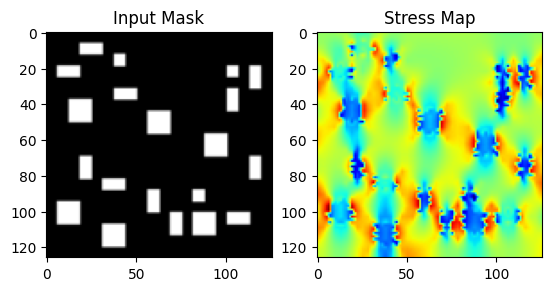

In [11]:

i=26
in_=dataset[i][0][0,:,:]
out=dataset[i][1][0,:,:]
#plot 2x1 grid
fig, axs = plt.subplots(1, 2)
axs[0].imshow(in_, cmap='gray')
axs[0].set_title('Input Mask')
axs[1].imshow(out, cmap='jet')
axs[1].set_title('Stress Map')
plt.show()


Ahora que la base de datos de mascaras y simulaciones de estres esta cargada correctamente, es posible iniciar el proceso de ingenieria de caracteriscas

#### a) Se aplicarán operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático.

Tres indiadores importantes puedes ser facilmente extraidos del mapa de estres, estos son, estres minimo, maximo y promedio

In [12]:
min_stress_list = []
max_stress_list = []
mean_stress_list = []

for i in range(len(dataset)):
    stress_map = dataset[i][1][0,:,:]
    min_stress_list.append(stress_map.min())
    max_stress_list.append(stress_map.max())
    mean_stress_list.append(stress_map.mean())

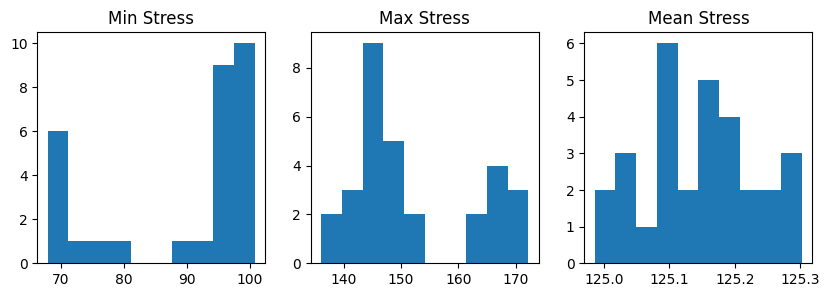

In [13]:
#visualize the distribution of the min, max and mean stress values
fig, axs = plt.subplots(1, 3)
axs[0].hist(min_stress_list)
axs[0].set_title('Min Stress')
axs[1].hist(max_stress_list)
axs[1].set_title('Max Stress')
axs[2].hist(mean_stress_list)
axs[2].set_title('Mean Stress')

fig.set_size_inches(10, 3)
plt.show()


Para explorar los datos de entrada(mascaras) la siguiente tecnias de manera que podamos extraer informacion de valor de las mascaras que posteriormente faciliten el entrenamiento de un modelo.

 - Escoletonizacion
 - Deteccion y medicion de bordes
 - calculo de fraccion de inclusiones

Esceletonizacion

Esta transformacion puede aportar valor porque los píxeles cercanos a los límites en la máscara pueden experimentar patrones de tensión diferentes a los que están más profundos dentro de una región. La transformación de distancia codifica esta información.

In [14]:
from skimage.morphology import skeletonize

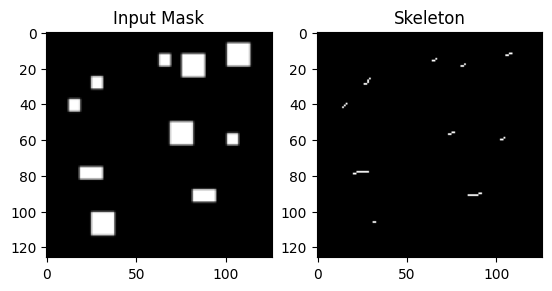

In [15]:
mask=dataset[i][0][0,:,:].numpy()

skel = skeletonize(mask)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(mask, cmap='gray')
axs[0].set_title('Input Mask')
axs[1].imshow(skel, cmap='gray')
axs[1].set_title('Skeleton')
plt.show()


#### b) Se utilizarán métodos de filtrado para la selección de características y técnicas de extracción de características, permitiendo reducir los requerimientos de almacenamiento, la complejidad del modelo y el tiempo de entrenamiento.

Deteccion y medicion de bordes

La longitud del borde de inclusión puede agregar valor al modelo de predicción de tensión porque proporciona una medida de cuánto interfaz existe entre diferentes fases de material (por ejemplo, inclusiones y la matriz). Esto influye directamente en la distribución de la tensión.

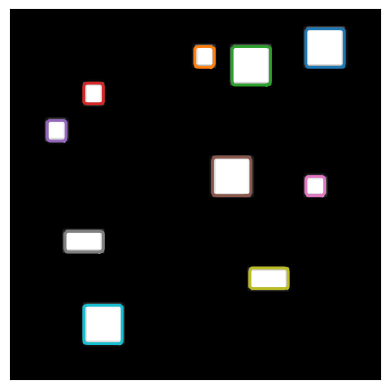

In [16]:
from skimage import measure

mask=dataset[i][0][0,:,:].numpy()
contours = measure.find_contours(mask, level=0.5)

fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

from skimage import measure
border_lengths = []
for i in range(len(dataset)):
    mask=dataset[i][0][0,:,:].numpy()
    contours = measure.find_contours(mask, level=0.5)

    total_border_length = sum(np.linalg.norm(np.diff(contour, axis=0), axis=1).sum() for contour in contours)
    border_lengths.append(total_border_length)




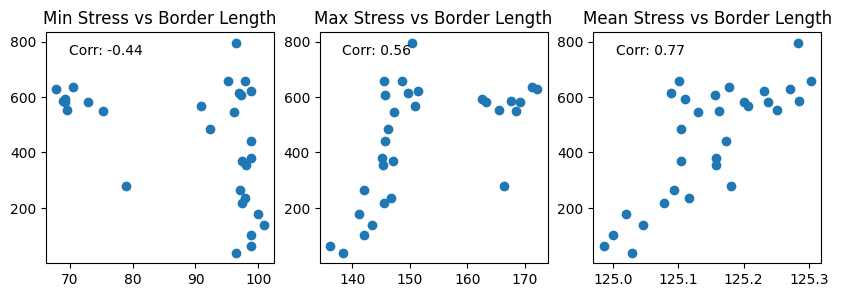

In [17]:
#plotting border length vs min, max, mean stress values
fig, axs = plt.subplots(1, 3)
corr = np.corrcoef(min_stress_list, border_lengths)[0, 1]
axs[0].scatter(min_stress_list, border_lengths)
axs[0].set_title('Min Stress vs Border Length')
axs[0].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[0].transAxes)

corr=np.corrcoef(max_stress_list, border_lengths)[0, 1]
axs[1].scatter(max_stress_list, border_lengths)
axs[1].set_title('Max Stress vs Border Length')
axs[1].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[1].transAxes)

corr=np.corrcoef(mean_stress_list, border_lengths)[0, 1]
axs[2].scatter(mean_stress_list, border_lengths)
axs[2].set_title('Mean Stress vs Border Length')
axs[2].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[2].transAxes)
#plot size
fig.set_size_inches(10,3)
plt.show()

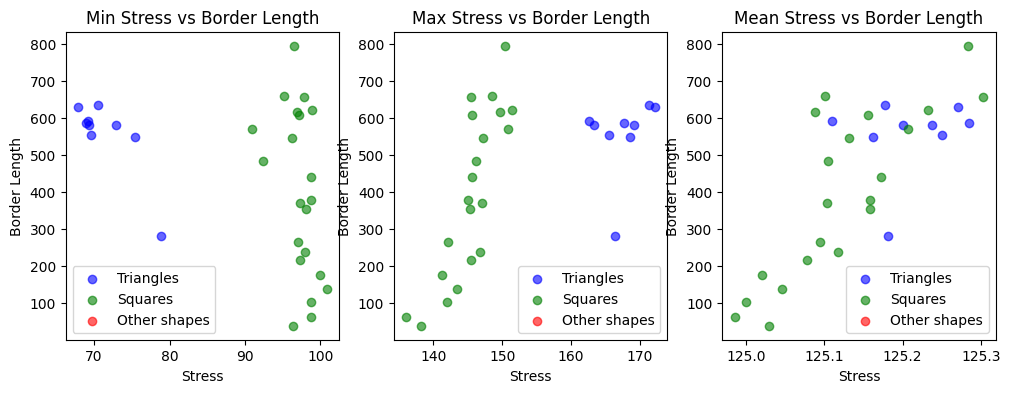

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.measure import approximate_polygon

# Mapa de colores basado en el número de aristas
color_map = {3: 'blue', 4: 'green', 'other': 'red'}
legend_labels = {3: "Triangles", 4: "Squares", 'other': "Other shapes"}

border_lengths = []
num_edges_list = []

for i in range(len(dataset)):
    mask = dataset[i][0][0,:,:].numpy()
    contours = measure.find_contours(mask, level=0.5)

    total_border_length = sum(np.linalg.norm(np.diff(contour, axis=0), axis=1).sum() for contour in contours)
    border_lengths.append(total_border_length)

    # Ajustar cada contorno a un polígono y contar aristas
    num_edges = []
    for contour in contours:
        approx = approximate_polygon(contour, tolerance=2)  # Tolerancia ajustable
        num_edges.append(len(approx) - 1)  # Restamos 1 porque se cierra el polígono

    avg_edges = int(np.mean(num_edges)) if num_edges else 3  # Promedio de aristas por máscara

    if avg_edges < 3:
        avg_edges = 3
    elif avg_edges > 4:
        avg_edges = 'other'

    num_edges_list.append(avg_edges)

# Graficar con los nuevos valores más precisos
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for j, (stress_list, title) in enumerate(zip(
        [min_stress_list, max_stress_list, mean_stress_list],
        ['Min Stress', 'Max Stress', 'Mean Stress'])):

    for edges_type in color_map.keys():
        idxs = [k for k, e in enumerate(num_edges_list) if e == edges_type]
        axs[j].scatter(
            [stress_list[k] for k in idxs],
            [border_lengths[k] for k in idxs],
            color=color_map[edges_type],
            label=legend_labels[edges_type],
            alpha=0.6)

    axs[j].set_title(f'{title} vs Border Length')
    axs[j].set_xlabel('Stress')
    axs[j].set_ylabel('Border Length')
    axs[j].legend()

plt.show()



**En "Min Stress vs Border Length" los triángulos están a la izquierda y los cuadrados a la derecha.**

Esto indica que los triángulos tienen valores de estrés mínimo más bajos.
Y los cuadrados tienen estrés mínimo más alto.
➝ Probablemente porque los triángulos distribuyen mejor las tensiones y evitan concentraciones de carga extrema en ciertas regiones.


**En "Max Stress vs Border Length" los triángulos están a la derecha y los cuadrados a la izquierda.**

Ahora los triángulos tienen valores de estrés máximo más altos.
Y los cuadrados tienen estrés máximo más bajo.
➝ Es posible que los triángulos concentren la carga en puntos específicos (como los vértices), lo que genera altos picos de estrés.

Proporcion de inclusiones

La fracción del área de inclusión (también llamada fracción de volumen en casos 3D) es una característica crucial en la modelización de la distribución de tensión. Describe cuánto del material está ocupado por inclusiones en comparación con la matriz y tiene un efecto directo en las propiedades mecánicas.

In [20]:
#inclusion fraction
inclusion_fractions = []
for i in range(len(dataset)):
    mask=dataset[i][0][0,:,:].numpy()
    inclusion_fraction = mask.sum() / mask.size
    inclusion_fractions.append(inclusion_fraction)

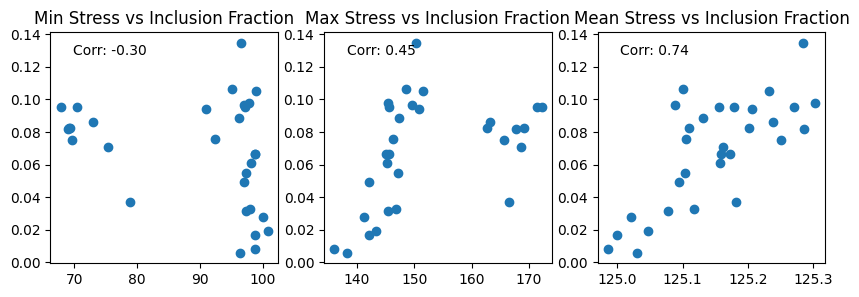

In [21]:
#plotting inclusion fraction vs min, max, mean stress values
fig, axs = plt.subplots(1, 3)
corr = np.corrcoef(min_stress_list, inclusion_fractions)[0, 1]
axs[0].scatter(min_stress_list, inclusion_fractions)
axs[0].set_title('Min Stress vs Inclusion Fraction')
axs[0].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[0].transAxes)

corr=np.corrcoef(max_stress_list, inclusion_fractions)[0, 1]
axs[1].scatter(max_stress_list, inclusion_fractions)
axs[1].set_title('Max Stress vs Inclusion Fraction')
axs[1].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[1].transAxes)

corr=np.corrcoef(mean_stress_list, inclusion_fractions)[0, 1]
axs[2].scatter(mean_stress_list, inclusion_fractions)
axs[2].set_title('Mean Stress vs Inclusion Fraction')
axs[2].text(0.1, 0.9, f'Corr: {corr:.2f}', transform=axs[2].transAxes)

#plot size
fig.set_size_inches(10,3)
plt.show()


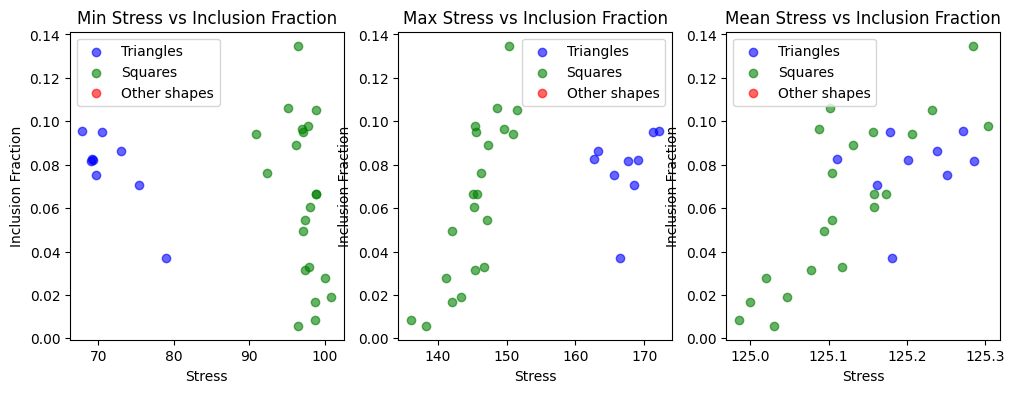

In [23]:
#plotting inclusion fraction vs min, max, mean stress values with color by number of edges
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for j, (stress_list, title) in enumerate(zip(
        [min_stress_list, max_stress_list, mean_stress_list],
        ['Min Stress', 'Max Stress', 'Mean Stress'])):

    for edges_type in color_map.keys():
        idxs = [k for k, e in enumerate(num_edges_list) if e == edges_type]
        axs[j].scatter(
            [stress_list[k] for k in idxs],
            [inclusion_fractions[k] for k in idxs],
            color=color_map[edges_type],
            label=legend_labels[edges_type],
            alpha=0.6)

    axs[j].set_title(f'{title} vs Inclusion Fraction')
    axs[j].set_xlabel('Stress')
    axs[j].set_ylabel('Inclusion Fraction')
    axs[j].legend()

plt.show()


En Min Stress vs Inclusion Fraction, los triángulos están a la izquierda y los cuadrados a la derecha.
En Max Stress vs Inclusion Fraction, los triángulos están a la derecha y los cuadrados a la izquierda.
Este mismo comportamiento se observó en Border Length, lo que sugiere que hay una relación entre la forma geométrica de las inclusiones y cómo se distribuye el estrés en el material.

**Posible Explicación:**

*Efecto de la Forma en la Distribución del Estrés*

Los triángulos crean concentraciones de esfuerzo más altas, especialmente en sus vértices. Esto puede hacer que el mínimo estrés en la matriz sea menor (zonas de alivio alrededor de inclusiones puntiagudas).
Y los cuadrados distribuyen el estrés de forma más uniforme, lo que hace que los mínimos sean más altos y los máximos sean más bajos en comparación con triángulos.

*Relación con la Fracción de Inclusión*

Los triángulos tienen menor área ocupada (menor fracción de inclusión), lo que podría permitir más redistribución del estrés en la matriz.
Mientras que los cuadrados ocupan más área, lo que podría llevar a una mayor homogenización del esfuerzo en el material.

*Interacción con el Border Length*

Los triángulos suelen tener un Border Length menor porque tienen menos lados.
Los cuadrados suelen tener un Border Length mayor.
Esto podría estar ligado al efecto de la fracción de inclusión en la redistribución del estrés.

# **"n-point spatial correlations (2-point)"**

La "2-point spatial correlation" (correlación espacial de dos puntos) es una técnica utilizada para analizar la estructura de materiales y cómo se distribuyen sus fases o inclusiones en el espacio. Se usa mucho en materiales compuestos y simulaciones de microestructuras.

El análisis de PCA (Análisis de Componentes Principales) sobre estas correlaciones permite reducir la dimensionalidad y encontrar patrones en la distribución de inclusiones dentro de la matriz.

Para esto, vamos a usar NumPy, SciPy y Scikit-Learn.

1. Cálculo de la correlación espacial de 2 puntos: El método más común para calcularla es usar la función de autocorrelación de Fourier (FFT), que permite analizar la estructura del material de forma eficiente.

2. Aplicar PCA: Una vez obtenidas las correlaciones espaciales, aplicamos PCA para reducir la dimensionalidad y extraer patrones principales.

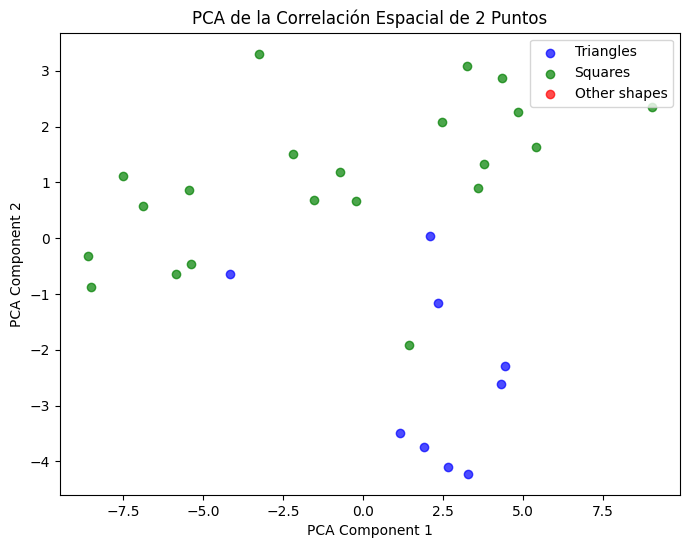

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftn, ifftn, fftshift
from sklearn.decomposition import PCA
from skimage import measure
from skimage.measure import approximate_polygon

# Definir colores y etiquetas
color_map = {3: 'blue', 4: 'green', 'other': 'red'}
legend_labels = {3: "Triangles", 4: "Squares", 'other': "Other shapes"}

def compute_2point_correlation(mask):
    """
    Calcula la correlación espacial de 2 puntos usando FFT
    """
    mask = mask.astype(float)
    fft_mask = fftn(mask)  # Transformada de Fourier
    autocorr = np.real(ifftn(np.abs(fft_mask) ** 2))  # Autocorrelación inversa
    autocorr = fftshift(autocorr)  # Centramos la correlación en la imagen
    autocorr /= autocorr.max()  # Normalizamos
    return autocorr

correlation_maps = []
num_edges_list = []

for i in range(len(dataset)):
    mask = dataset[i][0][0,:,:].numpy()

    # Calcular correlación de 2 puntos
    correlation = compute_2point_correlation(mask)
    correlation_maps.append(correlation.flatten())

    # Contar número de aristas
    contours = measure.find_contours(mask, level=0.5)
    num_edges = []

    for contour in contours:
        approx = approximate_polygon(contour, tolerance=2)
        num_edges.append(len(approx) - 1)  # Se resta 1 porque el polígono se cierra

    avg_edges = int(np.mean(num_edges)) if num_edges else 3

    if avg_edges < 3:
        avg_edges = 3
    elif avg_edges > 4:
        avg_edges = 'other'

    num_edges_list.append(avg_edges)

# Convertimos en matriz para PCA
correlation_matrix = np.array(correlation_maps)

# Aplicamos PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(correlation_matrix)

# Graficamos con colores
plt.figure(figsize=(8,6))
for edges_type in color_map.keys():
    idxs = [k for k, e in enumerate(num_edges_list) if e == edges_type]
    plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1],
                color=color_map[edges_type], label=legend_labels[edges_type], alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA de la Correlación Espacial de 2 Puntos")
plt.legend()
plt.show()



El hecho de que los cuadrados estén en la parte superior del gráfico y los triángulos en la parte inferior (salvo por un outlier en cada grupo) indica que existe una tendencia diferenciadora en la distribución espacial de sus correlaciones, aunque no sea una separación completamente definida.

**Agregando un tercer componente:**

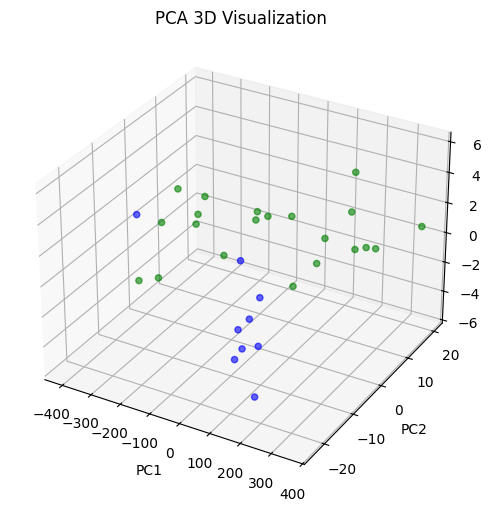

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# Convertir listas a arrays numpy para PCA
data_matrix = np.array(list(zip(min_stress_list, max_stress_list, mean_stress_list, border_lengths, inclusion_fractions)))

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
principal_components = pca.fit_transform(data_matrix)

# Asignar colores según la clasificación de formas
color_map = {3: 'blue', 4: 'green', 'other': 'red'}
colors = [color_map[num_edges_list[i]] for i in range(len(num_edges_list))]

# Graficar en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2], c=colors, alpha=0.6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA 3D Visualization')
plt.show()

Aplicación de K-Means Clustering

Se realiza un análisis de clustering con K-Means para verificar si los datos pueden agruparse en diferentes categorías de manera natural. Este enfoque ayuda a identificar patrones ocultos en la relación entre la fracción de inclusión, la longitud de borde y las tensiones.
La meta es encontrar agrupaciones coherentes que refuercen o contradigan la clasificación basada en el número de aristas.

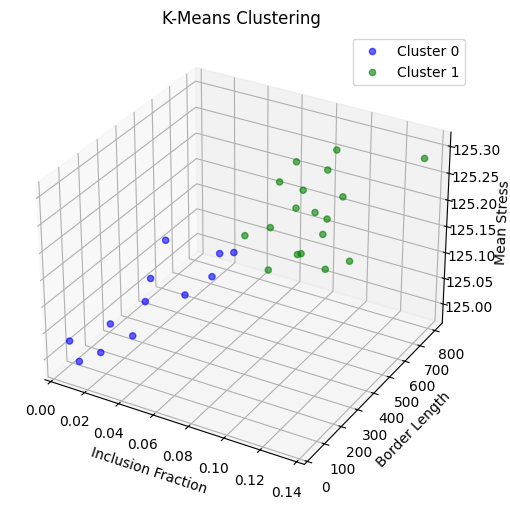

In [27]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos de entrada para el clustering (consideramos las 3 variables principales)
X = np.column_stack((inclusion_fractions, border_lengths, mean_stress_list))

# Aplicar K-Means con k=2 (triángulos y cuadrados)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Visualización en 3D con los clusters obtenidos
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Asignar colores a los clusters
colors = ['blue', 'green']
for cluster in range(2):
    idxs = np.where(labels == cluster)[0]
    ax.scatter(
        X[idxs, 0], X[idxs, 1], X[idxs, 2],
        c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6
    )

# Etiquetas
ax.set_xlabel('Inclusion Fraction')
ax.set_ylabel('Border Length')
ax.set_zlabel('Mean Stress')
ax.set_title('K-Means Clustering')
ax.legend()

plt.show()

La separación clara indica que los datos efectivamente tienen una estructura subyacente y que el K-Means pudo identificar dos agrupaciones bien definidas.

*   Cluster 0 (izquierda-abajo): Es posible que este grupo corresponda a formas con  menor fracción de inclusión y menor longitud de borde, lo que podría indicar que están más simplificadas geométricamente (posiblemente triángulos).
*   Cluster 1 (derecha-arriba): Podría representar formas con mayor fracción de inclusión y mayor longitud de borde, lo cual sugiere configuraciones más complejas (posiblemente cuadrados u otras formas).

La separación coincide con los triángulos y los cuadrados, esto confirma que estas variables realmente caracterizan bien las diferencias geométricas y su impacto en las tensiones.





Matriz Promedio de Correlación

El propósito de calcular esta matriz es identificar cómo se relacionan las distintas variables entre sí dentro del dataset. Esto nos permitirá ver si ciertas características, como la fracción de inclusión o la longitud del borde, están altamente correlacionadas con las tensiones mínimas, máximas o medias.

La idea es calcular la matriz de correlación para cada cluster (triángulos y cuadrados) por separado y compararlas, lo que puede darnos más información sobre cómo se comportan las variables en cada grupo.

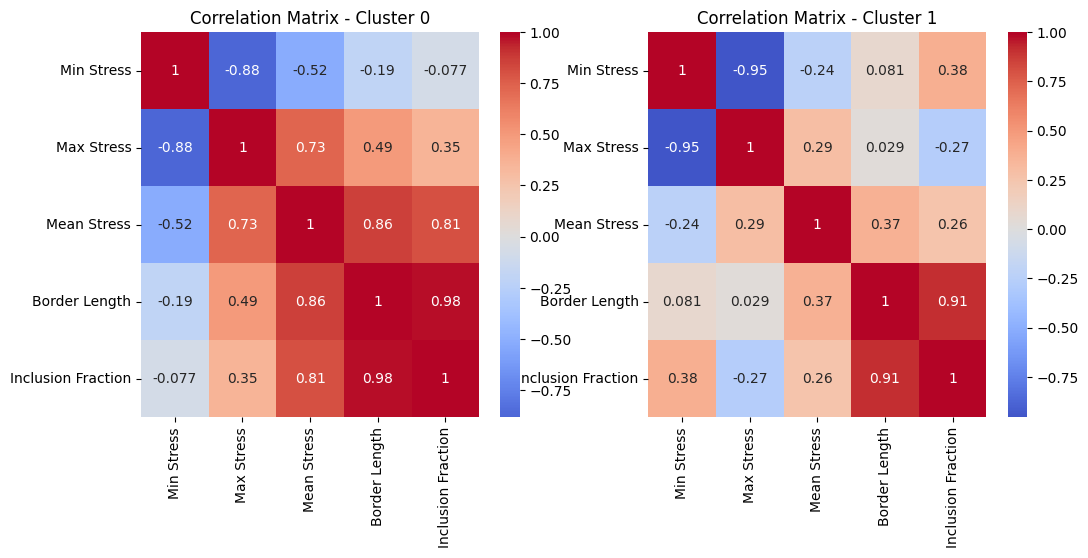

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear DataFrame con las variables relevantes
data = pd.DataFrame({
    'Min Stress': min_stress_list,
    'Max Stress': max_stress_list,
    'Mean Stress': mean_stress_list,
    'Border Length': border_lengths,
    'Inclusion Fraction': inclusion_fractions,
    'Cluster': kmeans.labels_  # Etiquetas del clustering
})

# Separar datos por cluster
cluster_0 = data[data['Cluster'] == 0].drop(columns=['Cluster'])
cluster_1 = data[data['Cluster'] == 1].drop(columns=['Cluster'])

# Calcular matrices de correlación
corr_matrix_0 = cluster_0.corr()
corr_matrix_1 = cluster_1.corr()

# Visualizar con heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(corr_matrix_0, annot=True, cmap='coolwarm', center=0, ax=axs[0])
axs[0].set_title('Correlation Matrix - Cluster 0')

sns.heatmap(corr_matrix_1, annot=True, cmap='coolwarm', center=0, ax=axs[1])
axs[1].set_title('Correlation Matrix - Cluster 1')

plt.show()

Conclusiones
Tecnicas de ingeniera de caracteristicas especificas para vision maquinca fueron utilizadas.

Es posible obersvar que tanto la longitud total de brodes como la fraccion de inclusiones tiene una buena correlacion con el estres promedio de la pieza, lo que puede ser muy util en la etapa de modelado porque reduce la cantidad de informacion de una matriz de 126X126 a una sola variable que por si sola tiene una correlacion de arriba del 0.70 con el estres promedio que se espera de la pieza.

Adicionalmente, el usa de la funcion "skeletonize" puede ser includa durante el entrenamiento del modelo para agregar informacion extra debido a que genera patrones relaciondos con la distancia del centro de las inclusiones con sus bordes y esquinas, que es donde comunmente se concentra el estres de un cuerpo bajo tension.